In [1]:
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import tensorflow as tf # thư viên tensorflow
import os
from sklearn.preprocessing import MinMaxScaler  # Lớp MinMaxScaler từ sklearn để chuẩn hóa dữ liệu
from keras.models import load_model  # Hàm load_model từ Keras để tải mô hình đã huấn luyện
import matplotlib.pyplot as plt  # Thư viện matplotlib.pyplot để vẽ biểu đồ
import matplotlib.gridspec as gridspec

# Lấy dữ liệu thực tế từ Yahoo

In [37]:
# Định nghĩa thư mục lưu trữ dữ liệu
data_dir = "YahooData"
csv_filename = "A.csv"
csv_filepath = os.path.join(data_dir, csv_filename)

# Tạo thư mục nếu chưa tồn tại
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# Kiểm tra xem tệp đã tồn tại trong thư mục hiện tại hay chưa
if os.path.exists(csv_filepath):
    # Nếu tệp đã tồn tại, đọc dữ liệu từ tệp CSV
    actual_data = pd.read_csv(csv_filepath, index_col='Date', parse_dates=True)
else:
    # Nếu tệp chưa tồn tại, tải dữ liệu thực tế từ Yahoo Finance
    ticker = "A"  # Mã chứng khoán
    start_date = "2023-04-30"  # Ngày bắt đầu của dữ liệu
    end_date = "2024-05-19"  # Ngày kết thúc của dư liệu
    actual_data = yf.download(ticker, start=start_date, end=end_date)
    if not actual_data.empty:
        # Lưu dữ liệu vào tệp CSV
        actual_data.to_csv(csv_filepath)
    else:
        raise ValueError("Không có dữ liệu để tải về. Kiểm tra lại mã chứng khoán và thời gian dữ liệu")

[*********************100%%**********************]  1 of 1 completed


# 1. Mô hình ML LTSM RNN

In [38]:
# Sử dụng MinMaxScaler để chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(actual_data[['Open', 'High', 'Low', 'Close', 'Volume']])

In [39]:
# Tạo chuỗi thời gian từ dữ liệu đã chuẩn hóa
sequence_length = 30 # Lấy 30 ngày gần nhất

def create_test_sequences(actual_data, sequence_length):
    sequences = []
    for i in range(len(actual_data) - sequence_length):
        sequences.append(actual_data[i:i + sequence_length])
    return np.array(sequences)

test_sequences = create_test_sequences(scaled_data, sequence_length)

In [40]:
# Tải mô hình đã huấn luyện
model = load_model('E:\\Nhom1_DoAnFocasting\\3. Mô hình RNN_Finance\\notebook\\stock_rnn_model.h5')

In [41]:
# Dự báo
predicted = model.predict(test_sequences)
predicted_prices = scaler.inverse_transform(predicted)
print (predicted)
print (predicted_prices)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
[[0.31438315 0.32652292 0.3258475  0.32650942 0.24870214]
 [0.3441034  0.35657272 0.3563742  0.35678402 0.23721796]
 [0.34073877 0.3533626  0.35215443 0.35304186 0.2568676 ]
 ...
 [0.92930007 0.9335607  0.935163   0.93414676 0.10776203]
 [0.98498756 0.9892428  0.9916327  0.9902188  0.09753484]
 [0.9830857  0.9868802  0.98908174 0.98772645 0.0913018 ]]
[[1.18851067e+02 1.19945305e+02 1.15122414e+02 1.18520706e+02
  2.25272700e+06]
 [1.20396812e+02 1.21525024e+02 1.16838921e+02 1.20129501e+02
  2.18195575e+06]
 [1.20221825e+02 1.21356270e+02 1.16601646e+02 1.19930641e+02
  2.30304650e+06]
 ...
 [1.50832901e+02 1.51857285e+02 1.49384216e+02 1.50810562e+02
  1.38418350e+06]
 [1.53729202e+02 1.54784500e+02 1.52559509e+02 1.53790222e+02
  1.32115850e+06]
 [1.53630280e+02 1.54660294e+02 1.52416061e+02 1.53657776e+02
  1.28274738e+06]]


In [42]:
# Chuẩn bị dữ liệu thực tế để so sánh
actual_prices = actual_data[['Open', 'High', 'Low', 'Close', 'Volume']][sequence_length:]
# Tạo DataFrame cho giá trị thực tế
actual_df = pd.DataFrame(actual_prices, columns=['Open', 'High', 'Low', 'Close', 'Volume']).reset_index(drop=True)
# Tạo DataFrame cho giá trị dự đoán
predicted_df = pd.DataFrame(predicted_prices, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

In [43]:
# Kết hợp dữ liệu thực tế và dự đoán vào cùng một DataFrame
combined = pd.concat([actual_df, predicted_df], axis=1)
combined.columns = ['Actual_Open', 'Actual_High', 'Actual_Low', 'Actual_Close', 'Actual_Volume',
                    'Pred_Open', 'Pred_High', 'Pred_Low', 'Pred_Close', 'Pred_Volume']

# Tên của các đặc trưng cần vẽ biểu đồ, tương ứng với các cột trong actual_prices và predicted_prices
targets = ['Open', 'High', 'Low', 'Close', 'Volume']

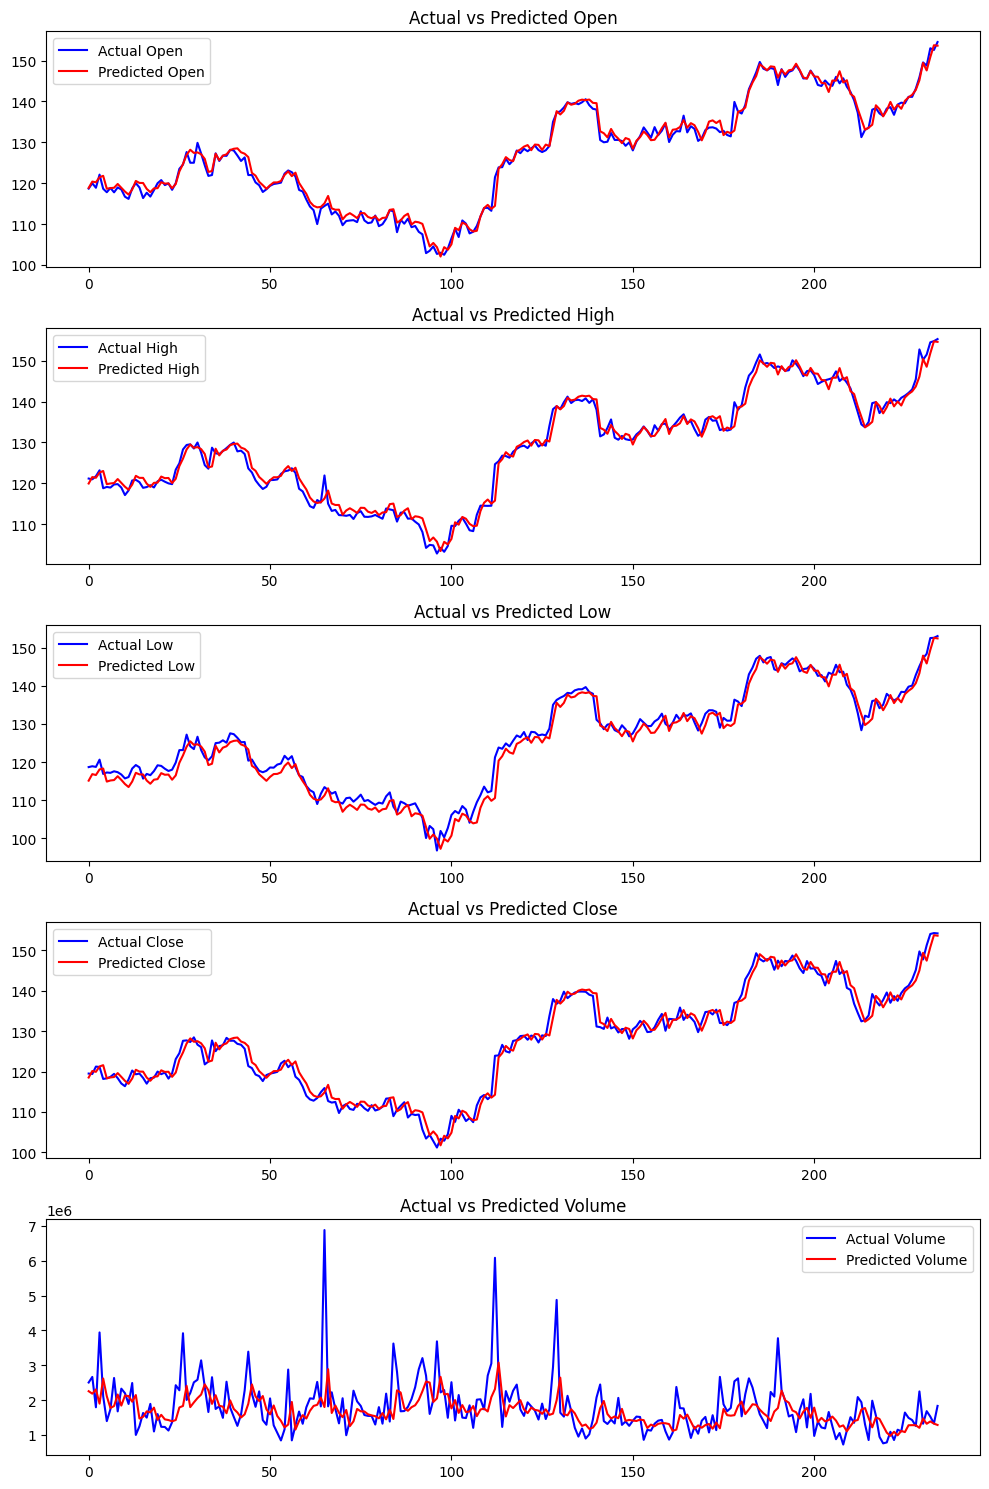

In [44]:
# Vẽ biểu đồ so sánh nhãn thực tế và nhãn dự đoán cho từng đặc trưng
fig, axes = plt.subplots(5, 1, figsize=(10, 15))  # Tạo 5 biểu đồ con

for i, feature in enumerate(targets):
    axes[i].plot(combined[f'Actual_{feature}'], label=f'Actual {feature}', color='blue')
    axes[i].plot(combined[f'Pred_{feature}'], label=f'Predicted {feature}', color='red')
    axes[i].set_title(f'Actual vs Predicted {feature}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [45]:
# Đánh giá mô hình LSTM RNN
results_lstm = {}
for feature in targets:
    mae = mean_absolute_error(combined[f'Actual_{feature}'], combined[f'Pred_{feature}'])
    mse = mean_squared_error(combined[f'Actual_{feature}'], combined[f'Pred_{feature}'])
    rmse = np.sqrt(mse)
    results_lstm[feature] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    print(f"{feature} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")

Open - MAE: 1.0083, MSE: 2.0360, RMSE: 1.4269
High - MAE: 1.2791, MSE: 3.1257, RMSE: 1.7680
Low - MAE: 1.7813, MSE: 4.7963, RMSE: 2.1900
Close - MAE: 1.5739, MSE: 4.3624, RMSE: 2.0886
Volume - MAE: 472874.2293, MSE: 535071188238.6754, RMSE: 731485.6036


# 2. Mô hình truyền thống Moving Average 

In [46]:
# Moving Average (Trung bình di động)
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
window = 30
for column in columns:
    # Tính toán giá trị trung bình di động 30 ngày cho từng cột
    actual_data[f'{column} Moving Average'] = actual_data[column].rolling(window=window).mean()

In [47]:
# Dự báo giá tiếp theo bằng phương pháp Moving Average
forecast_ma = {}
for column in columns:
    forecast_ma[column] = actual_data[f'{column} Moving Average'].iloc[-1]
    print(f'Dự báo giá tiếp theo của {column} bằng phương pháp Moving Average là: {forecast_ma[column]}')

Dự báo giá tiếp theo của Open bằng phương pháp Moving Average là: 141.75399831136068
Dự báo giá tiếp theo của High bằng phương pháp Moving Average là: 143.35199940999348
Dự báo giá tiếp theo của Low bằng phương pháp Moving Average là: 140.13233286539713
Dự báo giá tiếp theo của Close bằng phương pháp Moving Average là: 141.89099985758463
Dự báo giá tiếp theo của Volume bằng phương pháp Moving Average là: 1332123.3333333333


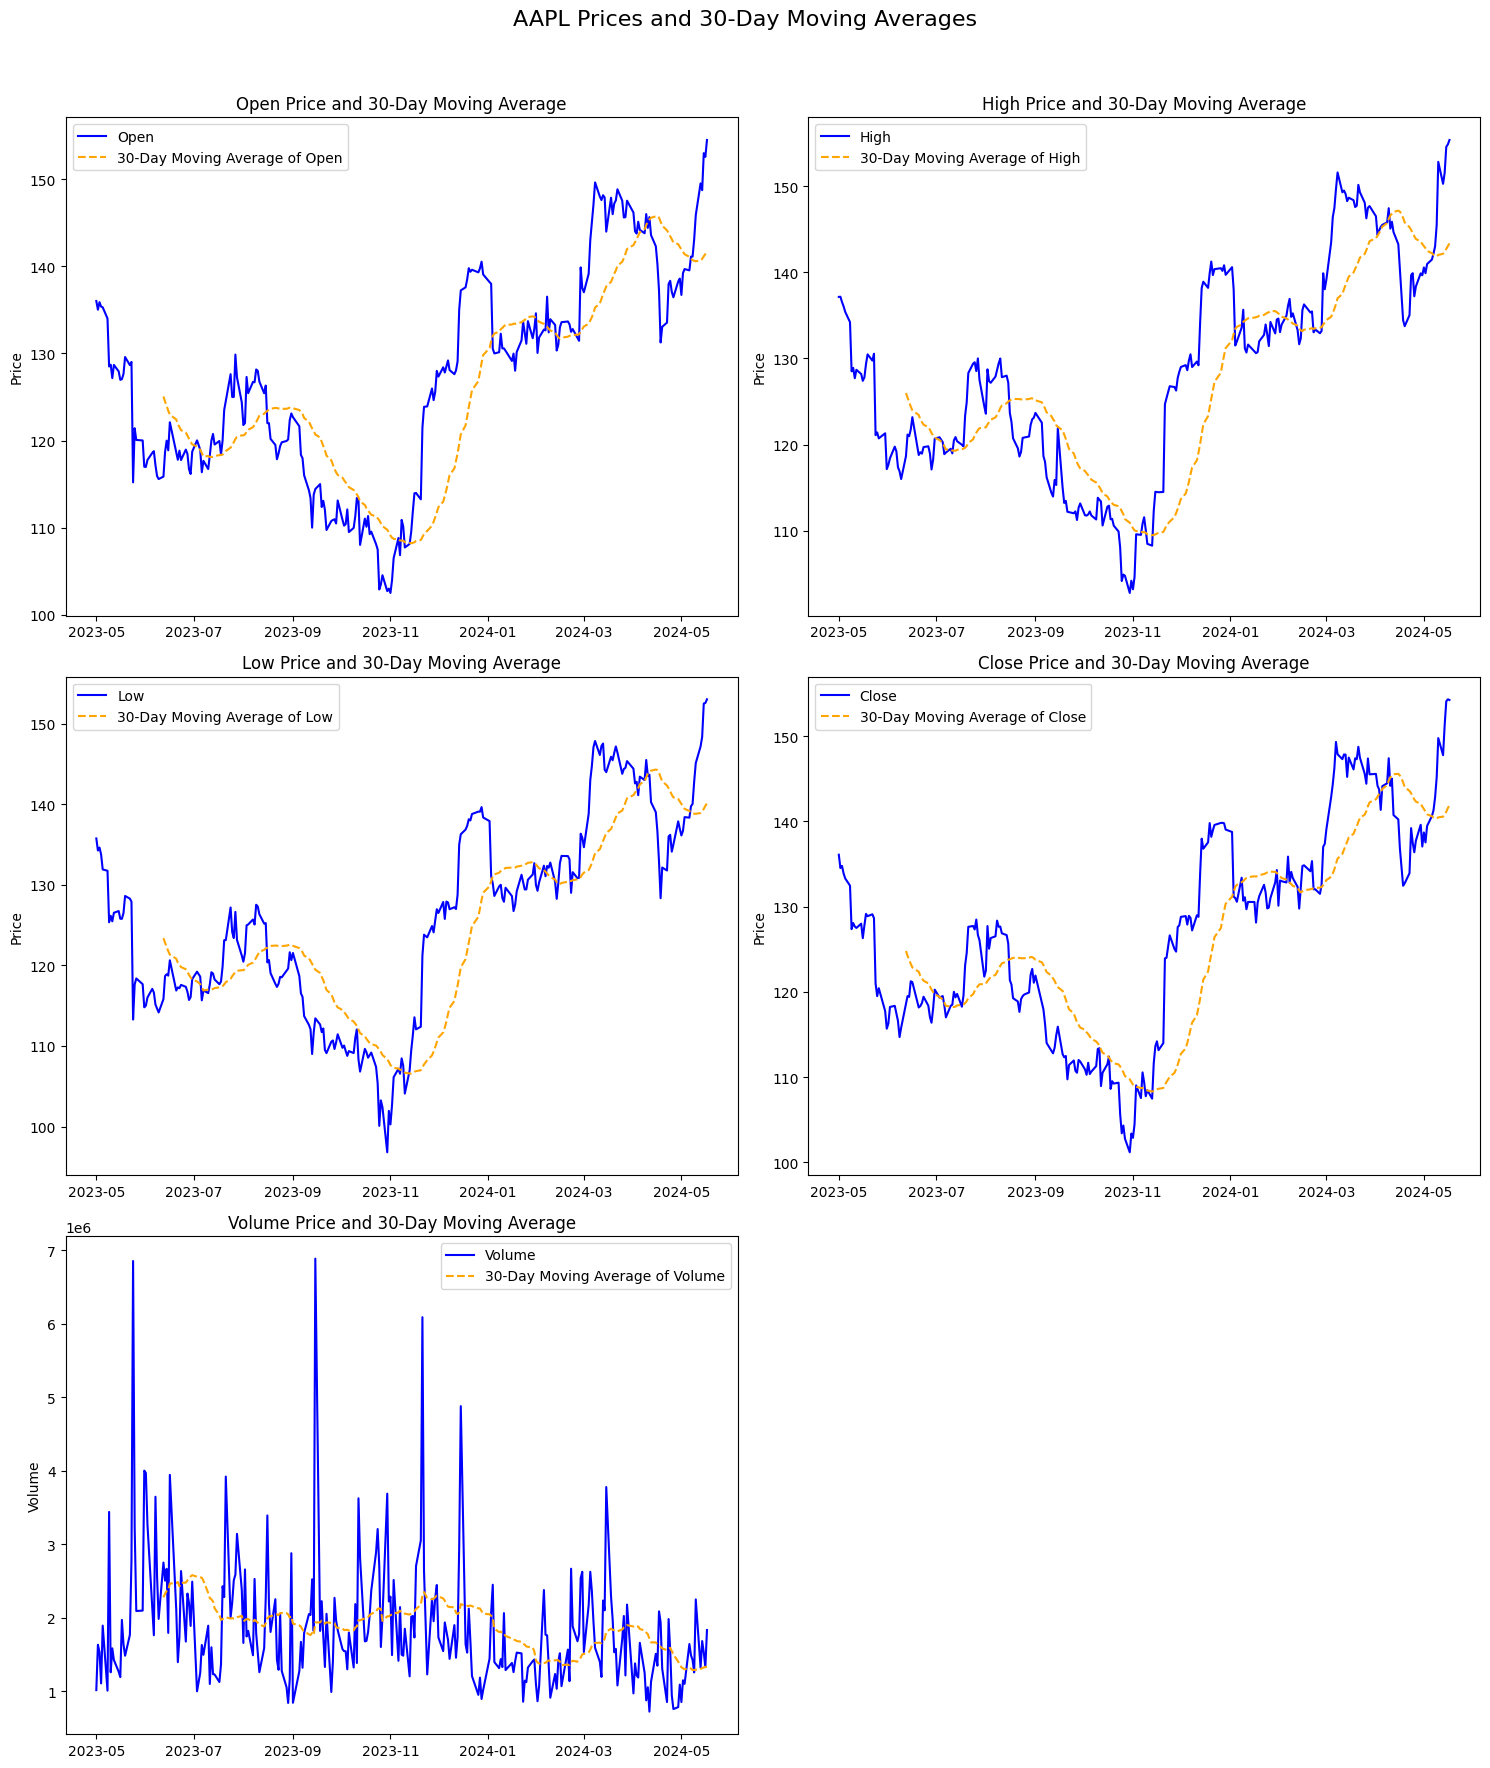

In [48]:
# Vẽ biểu đồ giá trị và trung bình di động cho từng cột
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
fig.suptitle(f'AAPL Prices and 30-Day Moving Averages', fontsize=16)

for i, column in enumerate(columns):
    ax = axes[i // 2, i % 2]
    ax.plot(actual_data[column], label=f'{column}', color='blue')
    ax.plot(actual_data[f'{column} Moving Average'], label=f'30-Day Moving Average of {column}', color='orange', linestyle='--')
    ax.set_title(f'{column} Price and 30-Day Moving Average')
    ax.set_ylabel('Price' if column != 'Volume' else 'Volume')
    ax.legend()

axes[2, 1].axis('off')  # Ẩn trục của ô trống
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [49]:
# Đánh giá mô hình Moving Average
results_ma = {}
for column in columns:
    actual = actual_data[column].iloc[window-1:]  # Dữ liệu thực tế (loại bỏ các giá trị NaN ban đầu)
    predicted = actual_data[f'{column} Moving Average'].iloc[window-1:]  # Dự báo từ moving average
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    results_ma[column] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    print(f'Đánh giá mô hình dự báo cho {column} (Moving Average):')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print('-'*50)


Đánh giá mô hình dự báo cho Open (Moving Average):
Mean Absolute Error (MAE): 5.303197811148262
Mean Squared Error (MSE): 46.83954656667021
Root Mean Squared Error (RMSE): 6.843942326369372
--------------------------------------------------
Đánh giá mô hình dự báo cho High (Moving Average):
Mean Absolute Error (MAE): 5.347251397472316
Mean Squared Error (MSE): 47.60706961558231
Root Mean Squared Error (RMSE): 6.899787650035493
--------------------------------------------------
Đánh giá mô hình dự báo cho Low (Moving Average):
Mean Absolute Error (MAE): 5.392814830198127
Mean Squared Error (MSE): 49.035742951169105
Root Mean Squared Error (RMSE): 7.0025526025278175
--------------------------------------------------
Đánh giá mô hình dự báo cho Close (Moving Average):
Mean Absolute Error (MAE): 5.341573282015527
Mean Squared Error (MSE): 47.478918099237774
Root Mean Squared Error (RMSE): 6.890494764473577
--------------------------------------------------
Đánh giá mô hình dự báo cho Volum

# 3. Mô hình truyền thống Exponnential Smoothing

In [50]:
# Hàm đánh giá dự báo
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

In [51]:
# Exponential Smoothing (Làm mịn hàm mũ)
validation_steps = 30  # Số bước để dự báo và đánh giá
forecast_es_results = []
# evaluation_es_results = []
forecast_index = pd.date_range(start=actual_data.index[-1] + pd.Timedelta(days=1), periods=validation_steps, freq='B')

for column in columns:
    data = actual_data[column].values
    model_es = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=12)
    fit_es = model_es.fit()
    forecast_es = fit_es.forecast(steps=validation_steps)
    actual_values = actual_data[column].values[-validation_steps:]
    if len(actual_values) < validation_steps:
        continue
    mae, mse, rmse = evaluate_forecast(actual_values, forecast_es)
    forecast_es_results.append(f"Giá trị {column} dự đoán ngày {forecast_index[0].date()} = {forecast_es[0]:.2f} (ES)")
    # evaluation_es_results.append(f"Đánh giá mô hình {column} (ES): MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

print("\nDự đoán cho ngày tiếp theo (Exponential Smoothing)")
for result in forecast_es_results:
    print(result)


Dự đoán cho ngày tiếp theo (Exponential Smoothing)
Giá trị Open dự đoán ngày 2024-05-20 = 154.63 (ES)
Giá trị High dự đoán ngày 2024-05-20 = 155.53 (ES)
Giá trị Low dự đoán ngày 2024-05-20 = 153.05 (ES)
Giá trị Close dự đoán ngày 2024-05-20 = 154.06 (ES)
Giá trị Volume dự đoán ngày 2024-05-20 = 1682729.54 (ES)


e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Số lượng phần tử trong forecast_es: 30
Số lượng phần tử trong forecast_index: 30


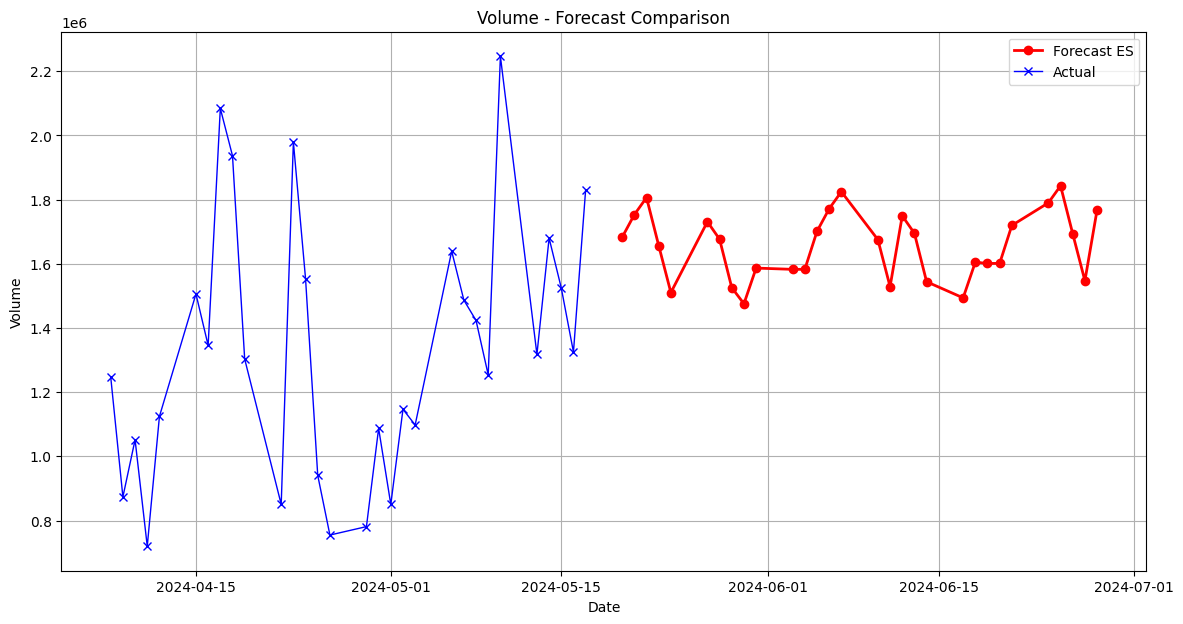

In [52]:
# In số lượng phần tử trong forecast_es và forecast_index
print("Số lượng phần tử trong forecast_es:", len(forecast_es))
print("Số lượng phần tử trong forecast_index:", len(forecast_index))
# Số lượng forecast_index và forecast_es sau khi đếm là 30 phần tử
# Lấy 30 phần tử cuối cùng của dữ liệu thực tế
actual_index = actual_data.index[-30:]
actual_values = actual_data[column][-30:]
plt.figure(figsize=(14, 7))
# Vẽ giá trị dự báo Exponential Smoothing
plt.plot(forecast_index, forecast_es, label='Forecast ES', color='red', linewidth=2, marker='o')
# Vẽ dữ liệu thực tế với 30 phần tử cuối cùng
plt.plot(actual_index, actual_values, label='Actual', color='blue', linewidth=1, marker='x')
plt.title(f'{column} - Forecast Comparison')
plt.xlabel('Date')
plt.ylabel(column)
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# Đánh giá mô hình Exponential Smoothing (Làm mịn hàm mũ)
validation_steps = 30  # Số bước để dự báo và đánh giá
results_es = {}
forecast_index = pd.date_range(start=actual_data.index[-1] + pd.Timedelta(days=1), periods=validation_steps, freq='B')

for column in columns:
    data = actual_data[column].values
    model_es = ExponentialSmoothing(data, trend='add', seasonal='add', seasonal_periods=12)
    fit_es = model_es.fit()
    forecast_es = fit_es.forecast(steps=validation_steps)
    actual_values = actual_data[column].values[-validation_steps:]
    if len(actual_values) < validation_steps:
        continue
    mae, mse, rmse = evaluate_forecast(actual_values, forecast_es)
    results_es[column] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    print(f"Đánh giá mô hình {column} (Exponential Smoothing): MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

Đánh giá mô hình Open (Exponential Smoothing): MAE: 12.97, MSE: 201.26, RMSE: 14.19
Đánh giá mô hình High (Exponential Smoothing): MAE: 12.33, MSE: 187.71, RMSE: 13.70
Đánh giá mô hình Low (Exponential Smoothing): MAE: 13.09, MSE: 211.01, RMSE: 14.53
Đánh giá mô hình Close (Exponential Smoothing): MAE: 12.46, MSE: 194.14, RMSE: 13.93
Đánh giá mô hình Volume (Exponential Smoothing): MAE: 468722.87, MSE: 299057336991.95, RMSE: 546861.35


e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


# 4. Mô hình truyền thống Arima

In [54]:
# Chọn các cột để xây dựng mô hình ARIMA
columns = ['Open', 'High', 'Low', 'Close', 'Volume']

In [55]:
# Hàm đánh giá dự báo
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mae, mse, rmse

e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

Đánh giá mô hình ARIMA (Open):
Mean Absolute Error (MAE): 5.157191987453872
Mean Squared Error (MSE): 37.822462049301
Root Mean Squared Error (RMSE): 6.149996914576543
--------------------------------------------------
Kết quả dự báo cho Open:
Date: 2024-04-08 00:00:00, Predicted: 144.08337892796524
Date: 2024-04-09 00:00:00, Predicted: 143.87404388989899
Date: 2024-04-10 00:00:00, Predicted: 143.93929481640356
Date: 2024-04-11 00:00:00, Predicted: 144.0159699930446
Date: 2024-04-12 00:00:00, Predicted: 143.90374763917487
Date: 2024-04-15 00:00:00, Predicted: 143.90152906983303
Date: 2024-04-16 00:00:00, Predicted: 143.88404066615672
Date: 2024-04-17 00:00:00, Predicted: 143.89609014034994
Date: 2024-04-18 00:00:00, Predicted: 143.8962390956539
Date: 2024-04-19 00:00:00, Predicted: 143.88475537050996
Date: 2024-04-22 00:00:00, Predicted: 143.88549297917857
Date: 2024-04-23 00:00:00, Predicted: 143.88415580636567
Date: 2024-04-24 00:00:00, Predicted: 143.8854817466387
Date: 2024-04-25 0

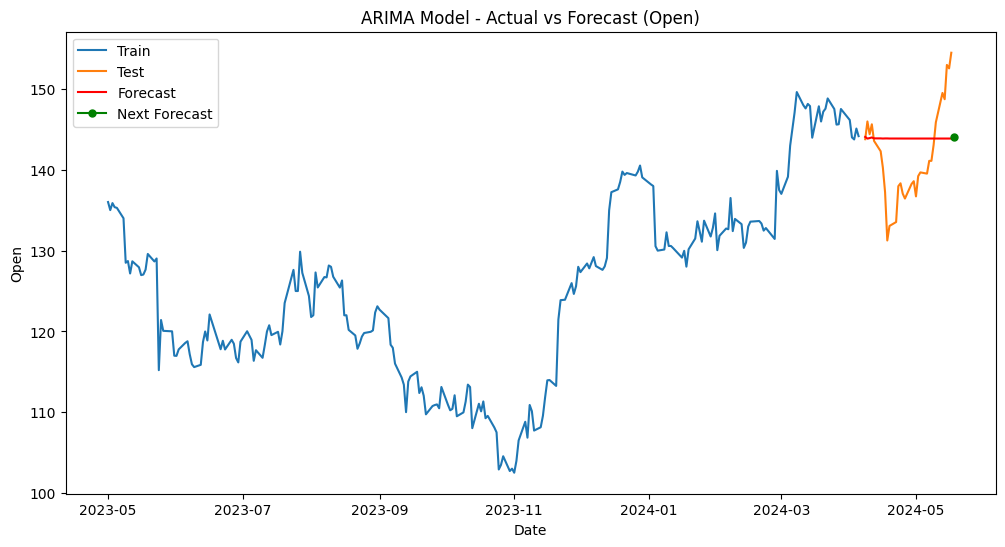

e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

Đánh giá mô hình ARIMA (High):
Mean Absolute Error (MAE): 5.3448671812366895
Mean Squared Error (MSE): 39.60618562732187
Root Mean Squared Error (RMSE): 6.293344550183302
--------------------------------------------------
Kết quả dự báo cho High:
Date: 2024-04-08 00:00:00, Predicted: 145.3432394420391
Date: 2024-04-09 00:00:00, Predicted: 145.22533793984832
Date: 2024-04-10 00:00:00, Predicted: 145.2735750667534
Date: 2024-04-11 00:00:00, Predicted: 145.3103155920353
Date: 2024-04-12 00:00:00, Predicted: 145.3191434373127
Date: 2024-04-15 00:00:00, Predicted: 145.30473414460585
Date: 2024-04-16 00:00:00, Predicted: 145.29908383051614
Date: 2024-04-17 00:00:00, Predicted: 145.3035840598174
Date: 2024-04-18 00:00:00, Predicted: 145.30633454038727
Date: 2024-04-19 00:00:00, Predicted: 145.3063221169203
Date: 2024-04-22 00:00:00, Predicted: 145.3051933662097
Date: 2024-04-23 00:00:00, Predicted: 145.30500802698958
Date: 2024-04-24 00:00:00, Predicted: 145.30540424531154
Date: 2024-04-25 00

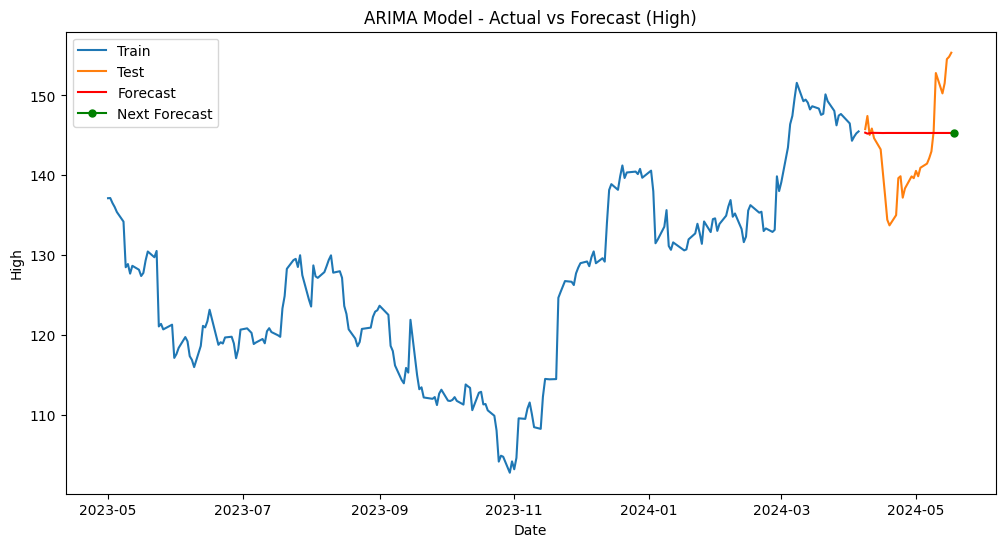

e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

Đánh giá mô hình ARIMA (Low):
Mean Absolute Error (MAE): 5.965497758864017
Mean Squared Error (MSE): 48.96106147611088
Root Mean Squared Error (RMSE): 6.997218124091236
--------------------------------------------------
Kết quả dự báo cho Low:
Date: 2024-04-08 00:00:00, Predicted: 143.42406618450917
Date: 2024-04-09 00:00:00, Predicted: 143.11654202259987
Date: 2024-04-10 00:00:00, Predicted: 143.31803842918285
Date: 2024-04-11 00:00:00, Predicted: 143.1851572897881
Date: 2024-04-12 00:00:00, Predicted: 143.29015642688262
Date: 2024-04-15 00:00:00, Predicted: 143.31111553982154
Date: 2024-04-16 00:00:00, Predicted: 143.27637258182008
Date: 2024-04-17 00:00:00, Predicted: 143.29724933432024
Date: 2024-04-18 00:00:00, Predicted: 143.28983862518368
Date: 2024-04-19 00:00:00, Predicted: 143.29244091062097
Date: 2024-04-22 00:00:00, Predicted: 143.2958719289608
Date: 2024-04-23 00:00:00, Predicted: 143.29282069680332
Date: 2024-04-24 00:00:00, Predicted: 143.29425743669273
Date: 2024-04-25 

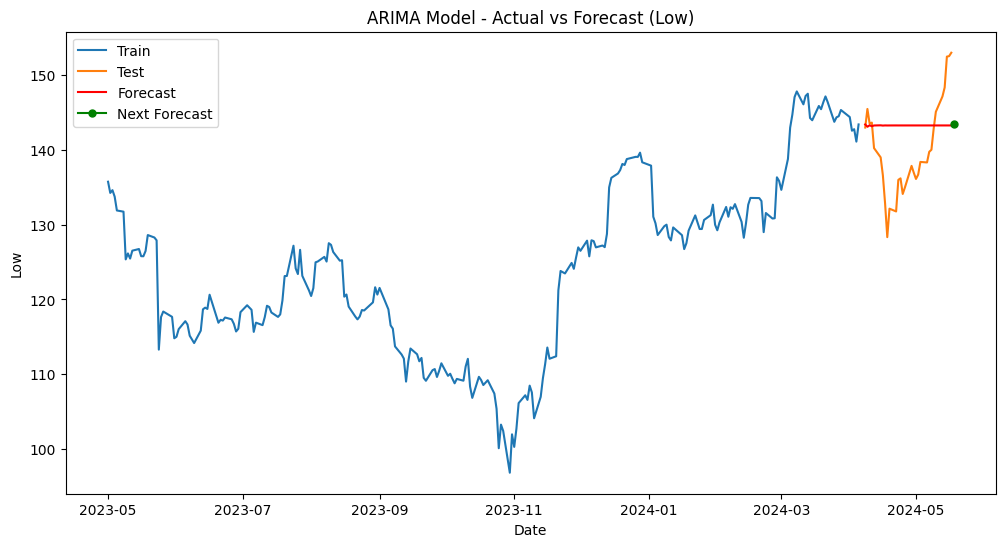

e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

Đánh giá mô hình ARIMA (Close):
Mean Absolute Error (MAE): 5.674942413142554
Mean Squared Error (MSE): 43.04934263688484
Root Mean Squared Error (RMSE): 6.561199786387002
--------------------------------------------------
Kết quả dự báo cho Close:
Date: 2024-04-08 00:00:00, Predicted: 143.9950499435907
Date: 2024-04-09 00:00:00, Predicted: 143.84889697123884
Date: 2024-04-10 00:00:00, Predicted: 143.94515657075328
Date: 2024-04-11 00:00:00, Predicted: 143.73428585245475
Date: 2024-04-12 00:00:00, Predicted: 143.96035888463064
Date: 2024-04-15 00:00:00, Predicted: 143.94542113879157
Date: 2024-04-16 00:00:00, Predicted: 143.92992423892426
Date: 2024-04-17 00:00:00, Predicted: 143.94847055201652
Date: 2024-04-18 00:00:00, Predicted: 143.9294786508764
Date: 2024-04-19 00:00:00, Predicted: 143.94802428137262
Date: 2024-04-22 00:00:00, Predicted: 143.94687111301772
Date: 2024-04-23 00:00:00, Predicted: 143.94521599392874
Date: 2024-04-24 00:00:00, Predicted: 143.94761643592688
Date: 2024-04

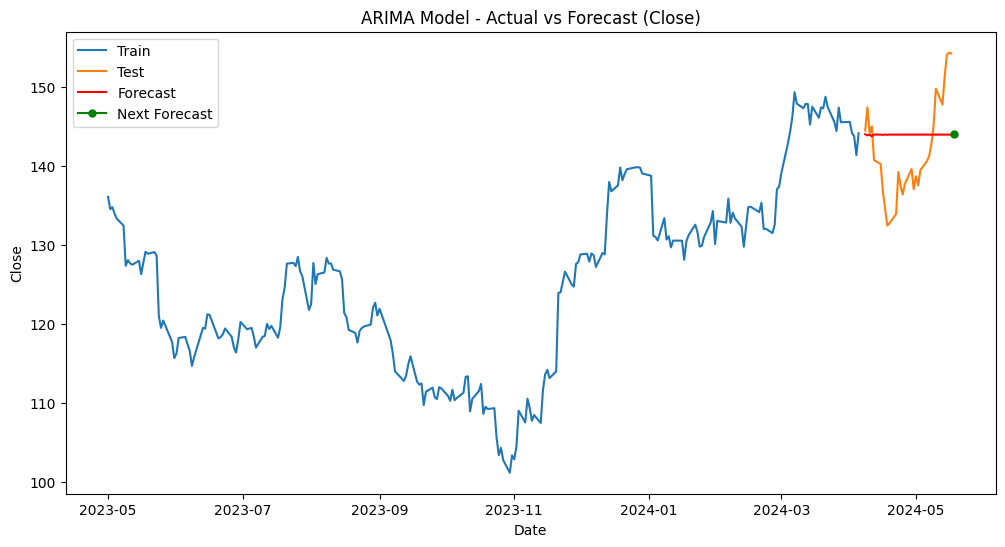

e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
e:\Nhom1_DoAnFocasting\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

Đánh giá mô hình ARIMA (Volume):
Mean Absolute Error (MAE): 335025.86735774664
Mean Squared Error (MSE): 165524250021.62283
Root Mean Squared Error (RMSE): 406846.71563332406
--------------------------------------------------
Kết quả dự báo cho Volume:
Date: 2024-04-08 00:00:00, Predicted: 1368540.1111070213
Date: 2024-04-09 00:00:00, Predicted: 1370220.087501504
Date: 2024-04-10 00:00:00, Predicted: 1324492.7134727752
Date: 2024-04-11 00:00:00, Predicted: 1362934.5737331174
Date: 2024-04-12 00:00:00, Predicted: 1414592.0099839335
Date: 2024-04-15 00:00:00, Predicted: 1386800.5664825623
Date: 2024-04-16 00:00:00, Predicted: 1375082.7071995365
Date: 2024-04-17 00:00:00, Predicted: 1367217.153199894
Date: 2024-04-18 00:00:00, Predicted: 1376611.537319594
Date: 2024-04-19 00:00:00, Predicted: 1384243.487755838
Date: 2024-04-22 00:00:00, Predicted: 1381236.9437712748
Date: 2024-04-23 00:00:00, Predicted: 1377787.5156994788
Date: 2024-04-24 00:00:00, Predicted: 1376397.054122807
Date: 2024-

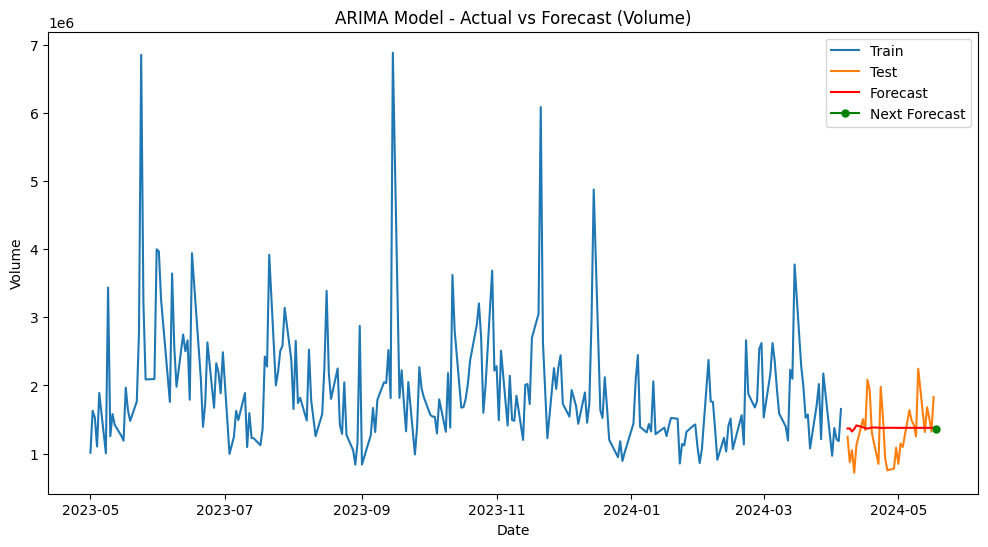

In [56]:
# Tạo biến lưu trữ kết quả đánh giá mô hình ARIMA
results_arima = {}
forecast_arima_results = {}  # Biến lưu trữ các giá trị dự báo

for column in columns:
    data = actual_data[[column]]

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    train_data = data.iloc[:-30]
    test_data = data.iloc[-30:]

    # Khởi tạo và huấn luyện mô hình ARIMA
    order = (5, 1, 0)  # Tham số (p, d, q) cho mô hình ARIMA
    model_arima = ARIMA(train_data, order=order)
    fit_arima = model_arima.fit()

    # Dự báo trên tập kiểm tra
    forecast_arima = fit_arima.forecast(steps=len(test_data))

    # Đánh giá mô hình ARIMA
    mae, mse, rmse = evaluate_forecast(test_data[column], forecast_arima)
    results_arima[column] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}
    forecast_arima_results[column] = forecast_arima  # Lưu trữ kết quả dự báo
    print(f'Đánh giá mô hình ARIMA ({column}):')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print('-'*50)

    # In ra kết quả dự báo
    print(f'Kết quả dự báo cho {column}:')
    for date, value in zip(test_data.index, forecast_arima):
        print(f'Date: {date}, Predicted: {value}')

    # Dự báo cho ngày tiếp theo
    next_forecast = fit_arima.forecast(steps=1).values[0]  # CHỈNH SỬA: Chuyển đổi thành giá trị đầu tiên
    next_date = test_data.index[-1] + pd.Timedelta(days=1)
    print(f'Dự báo cho ngày tiếp theo ({column}):')
    print(f'Date: {next_date}, Predicted: {next_forecast}')  # CHỈNH SỬA
    print('-'*50)
    # Vẽ biểu đồ so sánh giữa giá trị thực tế và dự báo cho mỗi cột
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data[column], label='Train')
    plt.plot(test_data.index, test_data[column], label='Test')
    plt.plot(test_data.index, forecast_arima, label='Forecast', color='red')
    plt.plot([next_date], [next_forecast], marker='o', markersize=5, color='green', label='Next Forecast')  # CHỈNH SỬA
    plt.title(f'ARIMA Model - Actual vs Forecast ({column})')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.legend()
    plt.show()


# 5. Biểu đồ so sánh LTSM RNN với các mô hình truyền thống

In [57]:
# Khởi tạo lại danh sách để lưu trữ các hàng dữ liệu đánh giá:
evaluation_df_list = []

In [58]:
# Tập hợp chỉ số đánh giá từ các mô hình và tạo biến
results = {
    'LSTM RNN': results_lstm,
    'Moving Average': results_ma,
    'Exponential Smoothing': results_es,
    'ARIMA': results_arima,
}

In [59]:
# Duyệt Qua Từ Điển results chứa tên các mô hình cần so sánh
for model, metrics in results.items():
    # Duyệt Qua Từ Điển metrics chứa tên các cột
    for column, values in metrics.items():
        # Tạo Một Từ Điển Hàng:
        row = {
            'Model': model,
            'Column': column,
            'MAE': values['MAE'],
            'MSE': values['MSE'],
            'RMSE': values['RMSE']
        }
        evaluation_df_list.append(row)


In [60]:
# Tạo các nhãn tên của các mô hình:
model_labels = ['LSTM RNN', 'Moving Average', 'Exponential Smoothing', 'ARIMA']

In [61]:
# Chuyển đổi danh sách evaluation_df_list thành DataFrame:
evaluation_df = pd.DataFrame(evaluation_df_list)

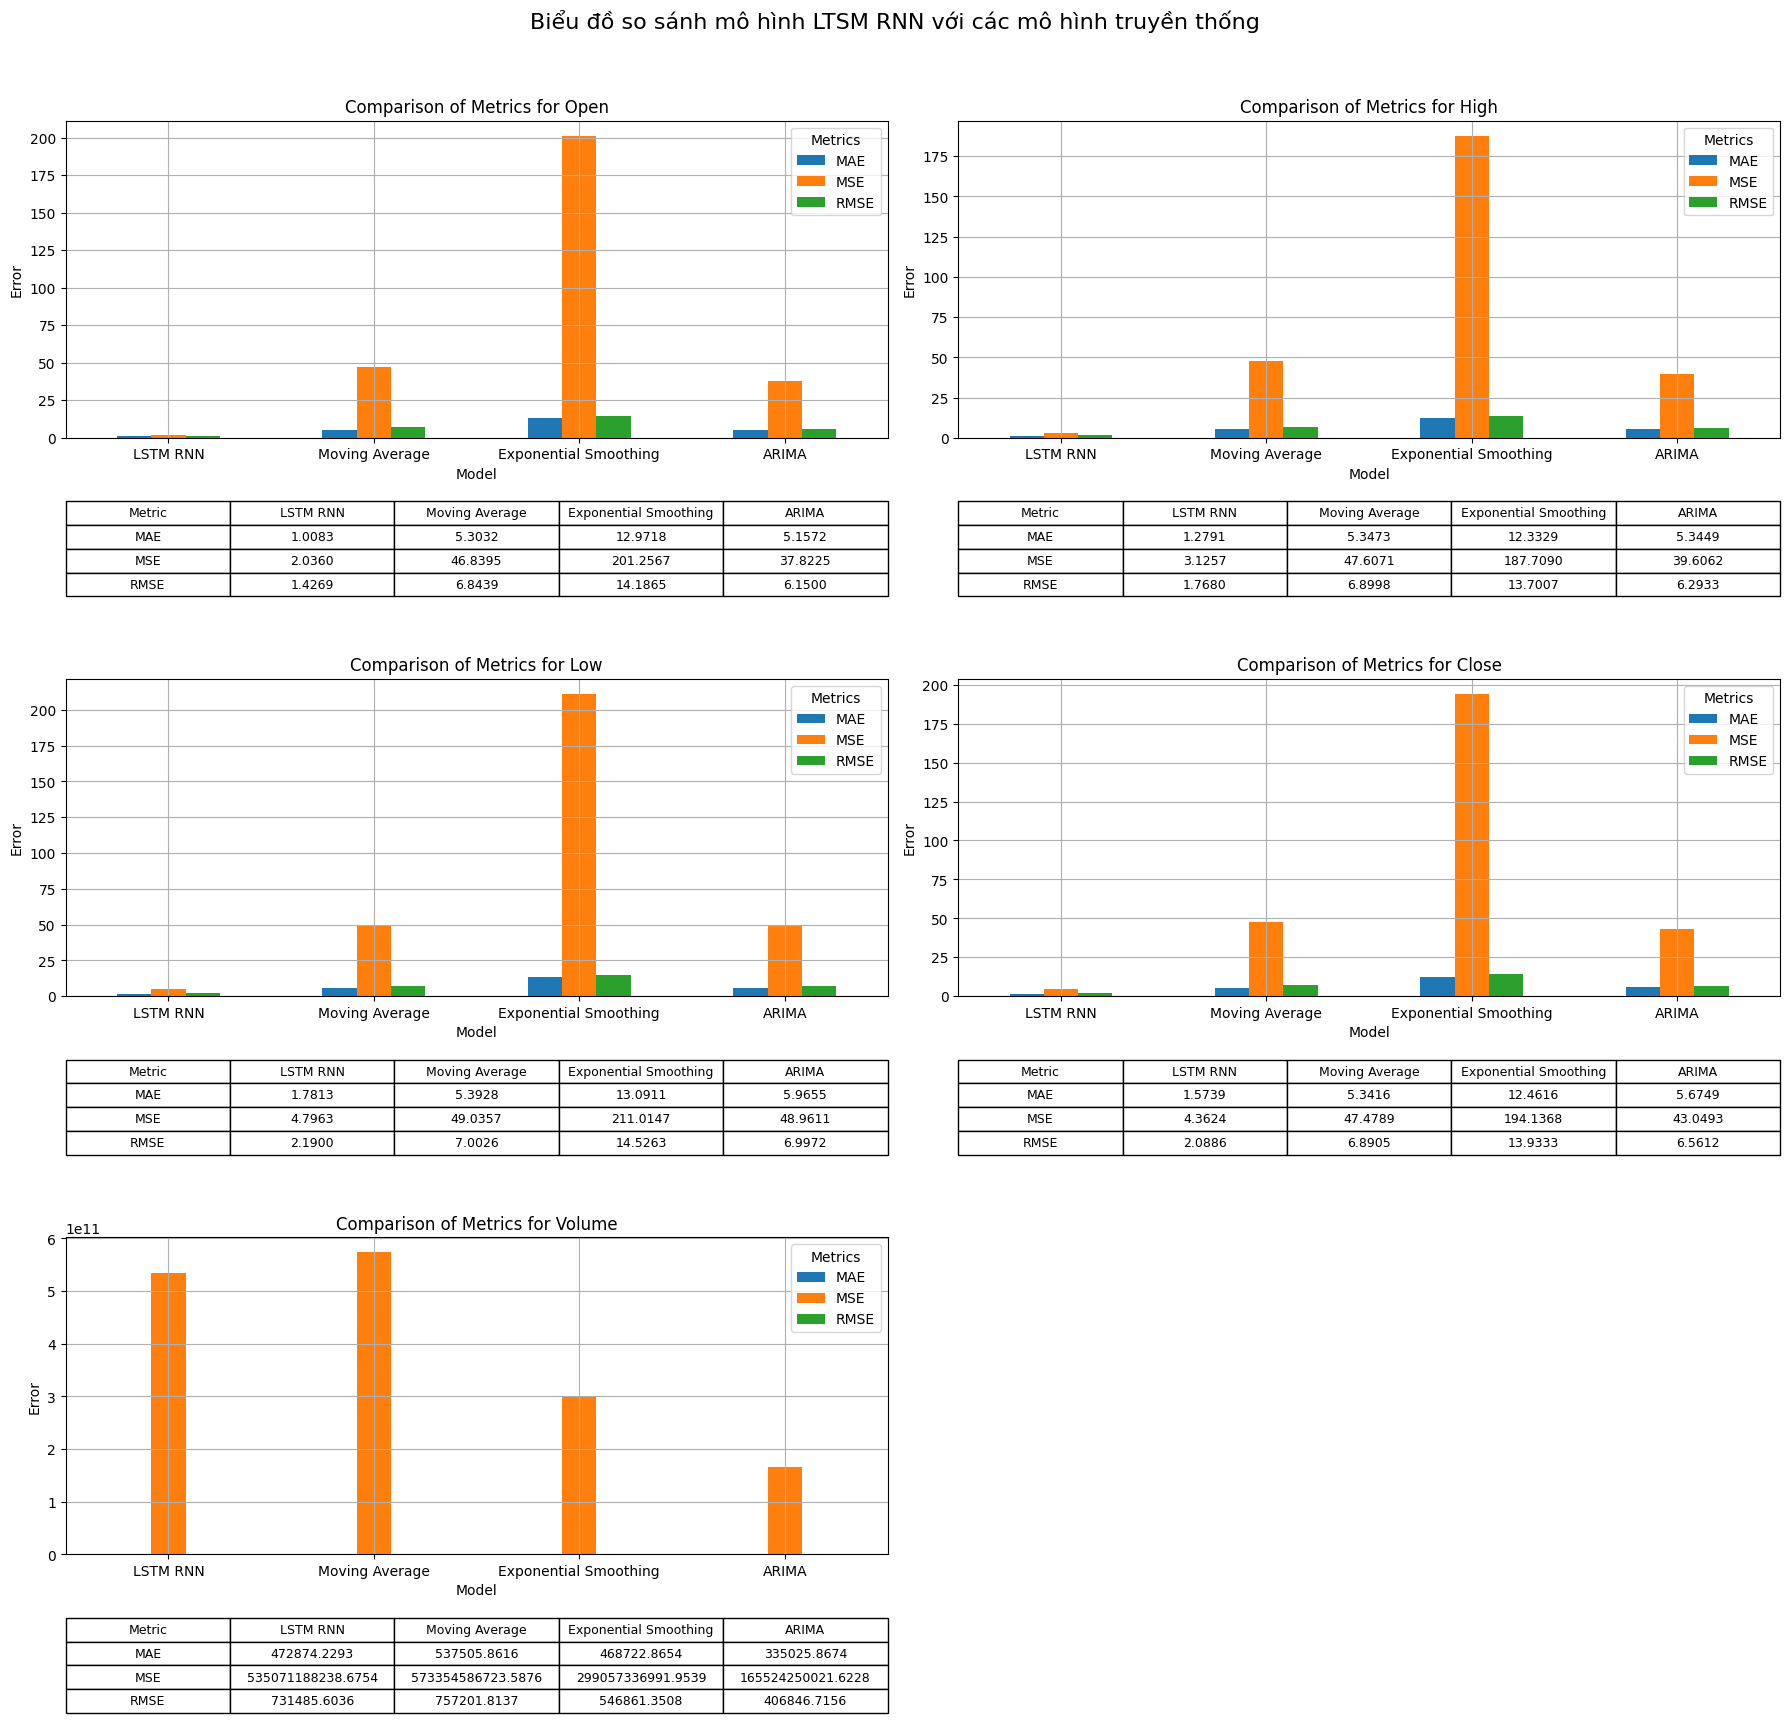

In [62]:
# Tạo các biểu đồ so sánh cho từng đặc trưng (nếu có nhiều đặc trưng)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
fig.suptitle('Biểu đồ so sánh mô hình LTSM RNN với các mô hình truyền thống', fontsize=16)
axes = axes.flatten()
metrics = ['MAE', 'MSE', 'RMSE']


for i, column in enumerate(columns):
    ax = axes[i]
    subset = evaluation_df[evaluation_df['Column'] == column]
    if not subset.empty:
        subset.set_index('Model')[metrics].plot(kind='bar', ax=ax)
        ax.set_title(f'Comparison of Metrics for {column}')
        ax.set_ylabel('Error')
        ax.set_xlabel('Model')
        ax.legend(title='Metrics')
        ax.grid(True)

# Thêm bảng dưới mỗi biểu đồ
    cell_text = []
    row_labels = metrics
    col_labels = ['Metric'] + model_labels
    for metric in metrics:
        row = [metric] + [f'{subset.loc[model, metric]:.4f}' for model in subset.index]
        cell_text.append(row)

    table = ax.table(cellText=cell_text, colLabels=col_labels, cellLoc='center', loc='bottom', bbox=[0, -0.5, 1, 0.3]) 
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(5, 5) 

# Xoay nhãn của các cột theo chiều ngang
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Ẩn các ô trống nếu số lượng columns không đủ
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()